### imports

In [1]:
import numpy as np
import pandas as pd
import hypertools as hyp
import brainiak.eventseg.event as event
import pickle
import os
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### paths

In [6]:
traj_dir = '../data analysis/trajectories/'
eventseg_dir = '../data analysis/event-segments/'

### data

In [4]:
# lecture trajectories
forces_v_traj = np.load(traj_dir+'forces_v_traj.npy')
bos_v_traj = np.load(traj_dir+'bos_v_traj.npy')

# question trajectories
forces_q_traj = np.load(traj_dir+'forces_q_traj.npy')
bos_q_traj = np.load(traj_dir+'bos_q_traj.npy')

# avg learning traces
avg_force_trace0 = np.load(traj_dir+'avg_force_trace0.npy')
avg_force_trace1 = np.load(traj_dir+'avg_force_trace1.npy')
avg_force_trace2 = np.load(traj_dir+'avg_force_trace2.npy')
avg_bos_trace0 = np.load(traj_dir+'avg_bos_trace0.npy')
avg_bos_trace1 = np.load(traj_dir+'avg_bos_trace1.npy')
avg_bos_trace2 = np.load(traj_dir+'avg_bos_trace2.npy')

# individual learning traces
with open(traj_dir+'forces_traces_set0.p', 'rb') as f:
    forces_traces_set0 = pickle.load(f)
    
with open(traj_dir+'forces_traces_set1.p', 'rb') as f:
    forces_traces_set1 = pickle.load(f)
    
with open(traj_dir+'forces_traces_set2.p', 'rb') as f:
    forces_traces_set2 = pickle.load(f)
    
with open(traj_dir+'bos_traces_set0.p', 'rb') as f:
    bos_traces_set0 = pickle.load(f)
    
with open(traj_dir+'bos_traces_set1.p', 'rb') as f:
    bos_traces_set1 = pickle.load(f)
    
with open(traj_dir+'bos_traces_set2.p', 'rb') as f:
    bos_traces_set2 = pickle.load(f)

### functions

In [30]:
def reduce_model(m, ev):
    """
    Reduce a model based on event labels
    """
    w = (np.round(ev.segments_[0])==1).astype(bool)
    return np.array([m[wi, :].mean(0) for wi in w.T])

# find optimal k for each lecture trajectory

In [7]:
lecture_ks = {'forces' : [], 'bos': []}

for lec_traj, key in zip([forces_v_traj, bos_v_traj], lecture_ks.keys()):
    
    corrmat = np.corrcoef(lec_traj)
    
    for n_events in range(1, 30):
        print(f'fitting {key} to {n_events} events...')
        ev = event.EventSegment(n_events)
        ev.fit(lec_traj)
        roundedmat = np.round(ev.segments_[0]).astype(int)
        mask = np.sum(list(map(lambda x: np.outer(x, x), roundedmat.T)), 0).astype(bool)
        within = corrmat[mask].mean()
        across = corrmat[~mask].mean()
        lecture_ks[key].append((within, across, within/across))

fitting forces to 1 events...


/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  


fitting forces to 2 events...
fitting forces to 3 events...
fitting forces to 4 events...
fitting forces to 5 events...
fitting forces to 6 events...
fitting forces to 7 events...
fitting forces to 8 events...
fitting forces to 9 events...
fitting forces to 10 events...
fitting forces to 11 events...
fitting forces to 12 events...
fitting forces to 13 events...
fitting forces to 14 events...
fitting forces to 15 events...
fitting forces to 16 events...
fitting forces to 17 events...
fitting forces to 18 events...
fitting forces to 19 events...
fitting forces to 20 events...
fitting forces to 21 events...
fitting forces to 22 events...
fitting forces to 23 events...
fitting forces to 24 events...
fitting forces to 25 events...
fitting forces to 26 events...
fitting forces to 27 events...
fitting forces to 28 events...
fitting forces to 29 events...
fitting bos to 1 events...
fitting bos to 2 events...
fitting bos to 3 events...
fitting bos to 4 events...
fitting bos to 5 events...
fitti

In [8]:
# with open(eventseg_dir + 'lecture_ks.p', 'wb') as f:
#     pickle.dump(lecture_ks, f)

In [ ]:
with open(eventseg_dir + 'lecture_ks.p', 'rb') as f:
    lecture_ks = pickle.load(f)

## plot within- & across-event correlations as a function of k

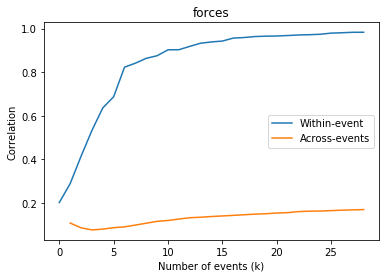

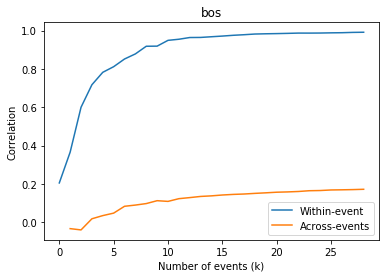

In [10]:
for lec, ks in lecture_ks.items():
    plt.plot(list(map(lambda x: x[0], ks)), label='Within-event')
    plt.plot(list(map(lambda x: x[1], ks)), label='Across-events')
    plt.title(lec)
    plt.legend()
    plt.xlabel('Number of events (k)')
    plt.ylabel('Correlation')
    plt.show()

## plot ratio of within- & across-event correlations as a function of k

forces: Max ratio at 26 events


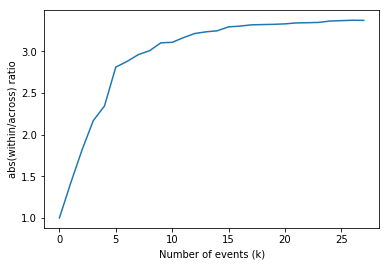

bos: Max ratio at 11 events


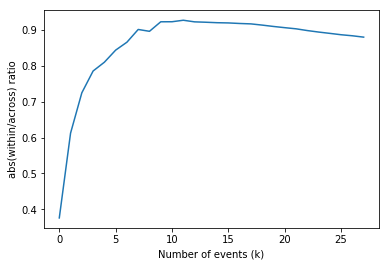

In [14]:
lec_max_ks = []
for lec, ks in lecture_ks.items():
#     t=list(map(lambda x: x[0]/(x[1]-min(ks[1])), ks))[1:]
    t=list(map(lambda x: x[0]/(x[1]-ks[1][2]), ks))[1:]
    t/=np.max(t)
    
    for i, v in enumerate(t):
        t[i]-=i/225    # regularization parameter (~5 x lecture window size)
    
    plt.plot(t)
    plt.ylabel('abs(within/across) ratio')
    plt.xlabel('Number of events (k)')
    print(f'{lec}: Max ratio at {np.argmax(t)} events')
    lec_max_ks.append((lec, np.argmax(t)))
    plt.show()

# fit eventseg model with optimal k, save fit model, segments, onset/offsets

In [33]:
for (lec_name, max_k), lec_traj  in zip(lec_max_ks, [forces_v_traj, bos_v_traj]):
    ev = event.EventSegment(max_k)
    ev.fit(lec_traj)
    lecture_events = reduce_model(lec_traj, ev)
    
    # save episodes' fit eventseg models
    with open(eventseg_dir+f'{lec_name}_eventseg_model.p', 'wb') as f:
        pickle.dump(ev, f)
    
    # save segmented episode models
    np.save(eventseg_dir+f'{lec_name}_events.npy', lecture_events)
    
    event_onsets_offsets = []
    
    # get onset/offset times
    for s in ev.segments_[0].T:
        tpts = np.where(np.round(s)==1)[0]
        event_onsets_offsets.append((tpts[0], tpts[-1]))
        
    # save onset/offset times
    with open(eventseg_dir+f'{lec_name}_event_times.p', 'wb') as f:
        pickle.dump(event_onsets_offsets, f)

# find optimal k for each learning trace